#1. Business Problem Statement :

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

Dataset:

https://drive.google.com/drive/folders/1mdgQscjqnCtdg7LGItomyK0abN6lcHBb

There are two csv files given

**train_1.csv**: In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:

**SPECIFIC NAME _ LANGUAGE.wikipedia.org _ACCESS TYPE_ACCESS ORIGIN**

having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

**Exog_Campaign_eng**: This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

**Concepts Tested:**

* Exploratory data analysis
* Time Series forecasting- ARIMA, SARIMAX, and Prophet

What does “good” look like?

* Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset
* Checking null values and understanding their reason.
* Understanding the page name format and splitting it to get different information.
* Separating different values from it like title, language, access type, and access origin.
* Visualizing the data and getting inferences from them
* Converting the data to a format that can be fed to the Arima model (Pivoting etc)
* Checking if the data is stationary
  * Dickey-Fuller test
* Trying different methods for stationarity.
  * Decomposition of series.
  * Differencing the series.
* Plotting the ACF and PACF plots
* Give insights about the characteristics of the time series.
* Modeling
  * Creating and training the Arima model
  * Getting the exogenous variable and using it to train a sarimax model
  * Use facebook prophet for forecasting
* Finding a way(grid search / etc) to find the best params for at least 1 modeling approach.
* Defining functions for all of the tasks.
* Comparing results for all languages and creating inferences and recommendations from them
* The MAPE for previous batches has been in the range of 4-8%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Importing required libraries -
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/content/drive/MyDrive/Exog_Campaign_eng')

In [ ]:
df.shape

(550, 1)

In [ ]:
df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [3]:
df2 = pd.read_csv('/content/drive/MyDrive/train_1.csv')

In [ ]:
df2.shape

(145063, 551)

In [ ]:
df2.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [ ]:
df2.describe()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,1.243230e+05,1.242470e+05,1.245190e+05,1.244090e+05,1.244040e+05,1.245800e+05,1.243990e+05,1.247690e+05,1.248190e+05,1.247210e+05,...,1.412100e+05,1.414790e+05,1.418740e+05,1.413190e+05,1.411450e+05,1.413620e+05,1.412410e+05,1.412370e+05,1.414280e+05,1.415980e+05
mean,1.195857e+03,1.204004e+03,1.133676e+03,1.170437e+03,1.217769e+03,1.290273e+03,1.239137e+03,1.193092e+03,1.197992e+03,1.189651e+03,...,1.394096e+03,1.377482e+03,1.393099e+03,1.523740e+03,1.679607e+03,1.678302e+03,1.633966e+03,1.684308e+03,1.467943e+03,1.478282e+03
std,7.275352e+04,7.421515e+04,6.961022e+04,7.257351e+04,7.379612e+04,8.054448e+04,7.576288e+04,6.820002e+04,7.149717e+04,7.214536e+04,...,8.574880e+04,7.732794e+04,8.478533e+04,8.752210e+04,9.794534e+04,9.232482e+04,9.185831e+04,9.014266e+04,8.155481e+04,8.873567e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,1.300000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.100000e+01,1.300000e+01,1.300000e+01,1.400000e+01,1.400000e+01,...,2.200000e+01,2.200000e+01,2.000000e+01,2.100000e+01,2.200000e+01,2.300000e+01,2.400000e+01,2.300000e+01,2.300000e+01,2.100000e+01
50%,1.090000e+02,1.080000e+02,1.050000e+02,1.050000e+02,1.130000e+02,1.130000e+02,1.150000e+02,1.170000e+02,1.150000e+02,1.130000e+02,...,1.490000e+02,1.430000e+02,1.320000e+02,1.450000e+02,1.600000e+02,1.620000e+02,1.630000e+02,1.600000e+02,1.540000e+02,1.360000e+02
75%,5.240000e+02,5.190000e+02,5.040000e+02,4.870000e+02,5.400000e+02,5.550000e+02,5.510000e+02,5.540000e+02,5.490000e+02,5.450000e+02,...,6.070000e+02,5.980000e+02,5.690000e+02,6.280000e+02,6.590000e+02,6.680000e+02,6.540000e+02,6.490000e+02,6.350000e+02,5.610000e+02
max,2.038124e+07,2.075219e+07,1.957397e+07,2.043964e+07,2.077211e+07,2.254467e+07,2.121089e+07,1.910791e+07,1.999385e+07,2.020182e+07,...,2.420108e+07,2.253925e+07,2.505662e+07,2.586575e+07,2.834288e+07,2.691699e+07,2.702505e+07,2.607382e+07,2.436397e+07,2.614954e+07


In [ ]:
df2.describe(include="all")

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,145063,1.243230e+05,1.242470e+05,1.245190e+05,1.244090e+05,1.244040e+05,1.245800e+05,1.243990e+05,1.247690e+05,1.248190e+05,...,1.412100e+05,1.414790e+05,1.418740e+05,1.413190e+05,1.411450e+05,1.413620e+05,1.412410e+05,1.412370e+05,1.414280e+05,1.415980e+05
unique,145063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2NE1_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.195857e+03,1.204004e+03,1.133676e+03,1.170437e+03,1.217769e+03,1.290273e+03,1.239137e+03,1.193092e+03,1.197992e+03,...,1.394096e+03,1.377482e+03,1.393099e+03,1.523740e+03,1.679607e+03,1.678302e+03,1.633966e+03,1.684308e+03,1.467943e+03,1.478282e+03
std,NaN,7.275352e+04,7.421515e+04,6.961022e+04,7.257351e+04,7.379612e+04,8.054448e+04,7.576288e+04,6.820002e+04,7.149717e+04,...,8.574880e+04,7.732794e+04,8.478533e+04,8.752210e+04,9.794534e+04,9.232482e+04,9.185831e+04,9.014266e+04,8.155481e+04,8.873567e+04
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,1.300000e+01,1.300000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.100000e+01,1.300000e+01,1.300000e+01,1.400000e+01,...,2.200000e+01,2.200000e+01,2.000000e+01,2.100000e+01,2.200000e+01,2.300000e+01,2.400000e+01,2.300000e+01,2.300000e+01,2.100000e+01
50%,NaN,1.090000e+02,1.080000e+02,1.050000e+02,1.050000e+02,1.130000e+02,1.130000e+02,1.150000e+02,1.170000e+02,1.150000e+02,...,1.490000e+02,1.430000e+02,1.320000e+02,1.450000e+02,1.600000e+02,1.620000e+02,1.630000e+02,1.600000e+02,1.540000e+02,1.360000e+02
75%,NaN,5.240000e+02,5.190000e+02,5.040000e+02,4.870000e+02,5.400000e+02,5.550000e+02,5.510000e+02,5.540000e+02,5.490000e+02,...,6.070000e+02,5.980000e+02,5.690000e+02,6.280000e+02,6.590000e+02,6.680000e+02,6.540000e+02,6.490000e+02,6.350000e+02,5.610000e+02


##Missing Values

In [ ]:
df2.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [ ]:
df2.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

#2. Exploratory Data Analysis

##2.1 Separating the data

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df2.Page[0]
#SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

'2NE1_zh.wikipedia.org_all-access_spider'

In [5]:
page=df2['Page'].str.rsplit("_",n=3,expand=True)
page.columns = ['Specific_Name','Langwiki','Access_type','Access_origin']

In [ ]:
page.head()

,Specific_Name,Langwiki,Access_type,Access_origin
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider


In [ ]:
page['Langwiki'].unique()

array(['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org',
       'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org',
       'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org'],
      dtype=object)

In [ ]:
page['Langwiki'].value_counts()

en.wikipedia.org         24108
ja.wikipedia.org         20431
de.wikipedia.org         18547
fr.wikipedia.org         17802
zh.wikipedia.org         17229
ru.wikipedia.org         15022
es.wikipedia.org         14069
commons.wikimedia.org    10555
www.mediawiki.org         7300
Name: Langwiki, dtype: int64

In [6]:
import re
def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res[0][0:2]
    return 'Null'

In [7]:
x = []
for i in page['Langwiki']:
  x.append(find_language(i))
page['Language'] = x

In [8]:
language_dict = {"es":"Spanish", "zh":"Chinese", "ru":"Russian", "fr":"French", "de":"German", "en":"English", "ja":"Japanese"}
page["Language"]=page["Language"].map(language_dict)

In [ ]:
page.head()

,Specific_Name,Langwiki,Access_type,Access_origin,Language
0,2NE1,zh.wikipedia.org,all-access,spider,Chinese
1,2PM,zh.wikipedia.org,all-access,spider,Chinese
2,3C,zh.wikipedia.org,all-access,spider,Chinese
3,4minute,zh.wikipedia.org,all-access,spider,Chinese
4,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider,Chinese


In [9]:
result = pd.concat([page,df2], axis=1, join='inner')

In [10]:
result.drop(['Page','Langwiki'],axis=1,inplace=True)
result.head()

,Specific_Name,Access_type,Access_origin,Language,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,all-access,spider,Chinese,18.0,11.0,5.0,13.0,14.0,9.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,all-access,spider,Chinese,11.0,14.0,15.0,18.0,11.0,13.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,all-access,spider,Chinese,1.0,0.0,1.0,1.0,0.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,all-access,spider,Chinese,35.0,13.0,10.0,94.0,4.0,26.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You,all-access,spider,Chinese,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
result.isna().sum()

Specific_Name        0
Access_type          0
Access_origin        0
Language         17855
2015-07-01       20740
                 ...  
2016-12-27        3701
2016-12-28        3822
2016-12-29        3826
2016-12-30        3635
2016-12-31        3465
Length: 554, dtype: int64

In [ ]:
result['Language'].isna().sum()

17855

In [11]:
result= result.loc[result['Language'].notnull()]

In [ ]:
result['Language'].isna().sum()

0

In [ ]:
result.shape

(127208, 554)

In [12]:
df_group = result.groupby(["Language"])[result.columns[4:]].median()
df_group.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
Language,,,,,,,,,,,,,,,,,,,,,
Chinese,72.0,68.0,67.0,69.0,72.0,65.5,68.0,71.0,74.0,76.0,...,107.0,107.0,109.0,119.0,115.0,117.0,117.5,110.0,109.0,106.0
English,243.0,242.0,221.0,215.0,232.0,248.0,258.0,259.0,263.0,242.0,...,517.0,484.0,422.0,449.0,523.0,587.0,578.0,579.0,554.0,481.0
French,101.0,102.0,100.0,100.0,112.0,108.0,107.0,109.5,105.0,98.0,...,164.0,159.0,144.0,157.0,191.0,194.0,193.0,190.0,193.0,166.0
German,99.0,97.0,95.0,96.0,113.0,108.5,110.0,115.0,113.0,104.0,...,130.0,122.0,107.0,148.0,157.0,162.0,162.0,160.0,152.0,127.0
Japanese,172.0,167.0,176.0,192.0,190.0,179.0,178.0,179.0,179.0,176.0,...,224.0,251.0,241.0,243.0,228.0,237.0,226.0,240.0,246.0,232.0


##2.2 Analyzing and visualizing the data

In [ ]:
result["Access_type"].value_counts()

all-access    65713
mobile-web    30923
desktop       30572
Name: Access_type, dtype: int64

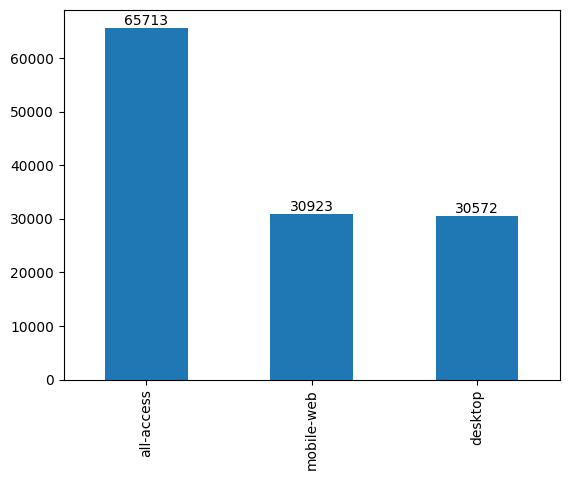

In [ ]:
result["Access_type"].value_counts().plot(kind="bar")
for i, count in enumerate(result['Access_type'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

In [ ]:
result["Access_origin"].value_counts()

all-agents    96594
spider        30614
Name: Access_origin, dtype: int64

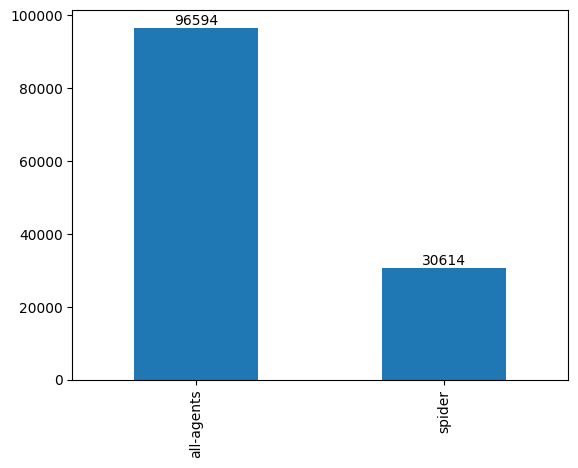

In [ ]:
result["Access_origin"].value_counts().plot(kind="bar")
for i, count in enumerate(result["Access_origin"].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

In [ ]:
page.Language.value_counts()

English     24108
Japanese    20431
German      18547
French      17802
Chinese     17229
Russian     15022
Spanish     14069
Name: Language, dtype: int64

In [81]:
round(page.Language.value_counts()/len(page.Language)*100,2)

English     16.62
Japanese    14.08
German      12.79
French      12.27
Chinese     11.88
Russian     10.36
Spanish      9.70
Name: Language, dtype: float64

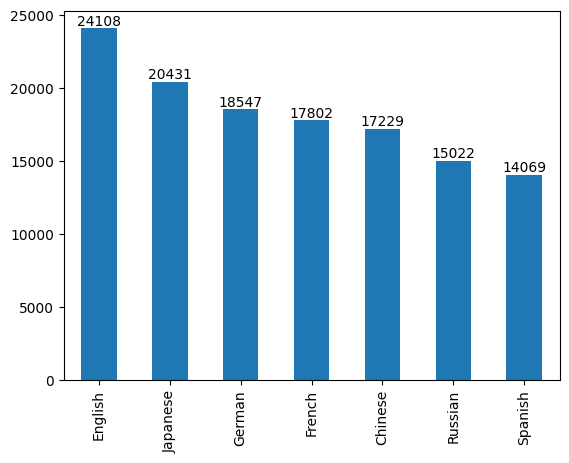

In [ ]:
page.Language.value_counts().plot(kind="bar")
for i, count in enumerate(page.Language.value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

##2.3 Getting inferences

* English and Spanish have the higher median values
* Chinese has the lowest median value
* All Access type has the highest percentage of access type which is more than 50 %
* All agents access origin has the highest percentage of acess origin type of above 75 %


#3. Checking stationarity

Null hypothesis: TS is non-stationary.

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the Critical Value', we can reject the null hypothesis and say that the series is stationary.


##3.1 Formatting the data for the model


In [13]:
data_TimeSeries = df_group.T
data_TimeSeries.index = np.vectorize(lambda x: np.datetime64(x))(data_TimeSeries.index)
data_TimeSeries.head()

Language,Chinese,English,French,German,Japanese,Russian,Spanish
2015-07-01,72.0,243.0,101.0,99.0,172.0,180.0,368.0
2015-07-02,68.0,242.0,102.0,97.0,167.0,183.0,362.0
2015-07-03,67.0,221.0,100.0,95.0,176.0,182.0,322.0
2015-07-04,69.0,215.0,100.0,96.0,192.0,177.0,261.0
2015-07-05,72.0,232.0,112.0,113.0,190.0,189.0,311.0


In [ ]:
data_TimeSeries.isna().sum()

Language
Chinese     0
English     0
French      0
German      0
Japanese    0
Russian     0
Spanish     0
dtype: int64

Time Series plot: all 7 languages

(array([16617., 16679., 16740., 16801., 16861., 16922., 16983., 17045.,
        17106., 17167.]),
 [Text(16617.0, 0, '2015-07'),
  Text(16679.0, 0, '2015-09'),
  Text(16740.0, 0, '2015-11'),
  Text(16801.0, 0, '2016-01'),
  Text(16861.0, 0, '2016-03'),
  Text(16922.0, 0, '2016-05'),
  Text(16983.0, 0, '2016-07'),
  Text(17045.0, 0, '2016-09'),
  Text(17106.0, 0, '2016-11'),
  Text(17167.0, 0, '2017-01')])

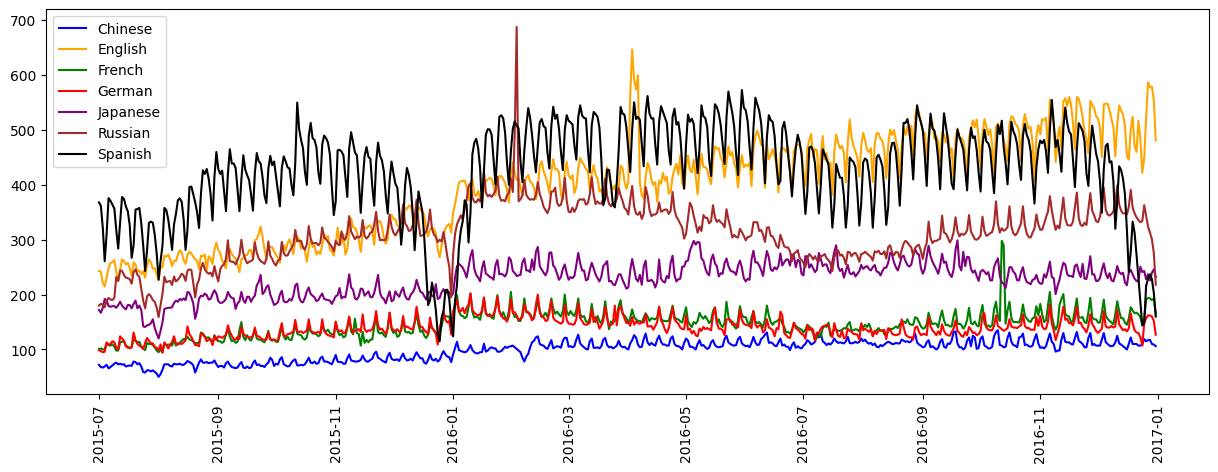

In [ ]:
plt.figure(figsize=(15,5))
lang = list(data_TimeSeries.columns); clr = ["blue","orange","green","red","purple","brown","black"]
for i in range(len(lang)):
    plt.plot(data_TimeSeries.index, data_TimeSeries[lang[i]], color=clr[i], label=lang[i])
plt.legend(); plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Chinese'),
  Text(1, 0, 'English'),
  Text(2, 0, 'French'),
  Text(3, 0, 'German'),
  Text(4, 0, 'Japanese'),
  Text(5, 0, 'Russian'),
  Text(6, 0, 'Spanish')])

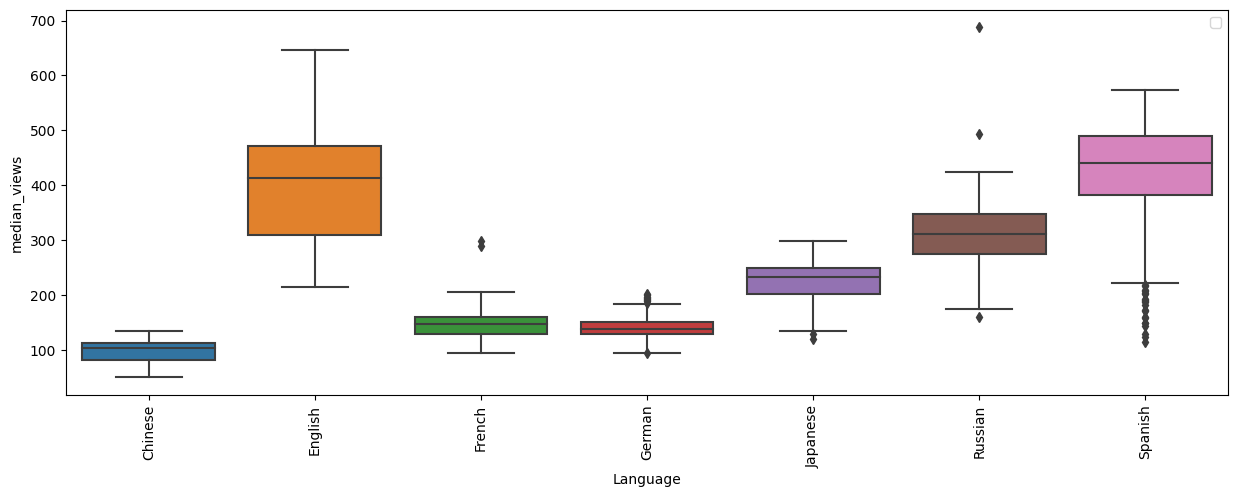

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_TimeSeries.reset_index().melt(id_vars=["index"],value_vars=data_TimeSeries.columns).set_index("index"), y="value",x="Language")
plt.ylabel("median_views")
plt.legend(); plt.xticks(rotation = 90)

In [ ]:
data_TimeSeries.median(axis=0).sort_values(ascending=False)

Language
Spanish     441.25
English     412.50
Russian     311.50
Japanese    233.50
French      147.00
German      138.00
Chinese     104.00
dtype: float64

In [ ]:
Lg = data_TimeSeries.median(axis=0).sort_values(ascending=False)/data_TimeSeries.median(axis=0).sort_values(ascending=False).sum()*100
Lg

Language
Spanish     24.681863
English     23.073696
Russian     17.424136
Japanese    13.061110
French       8.222626
German       7.719200
Chinese      5.817368
dtype: float64

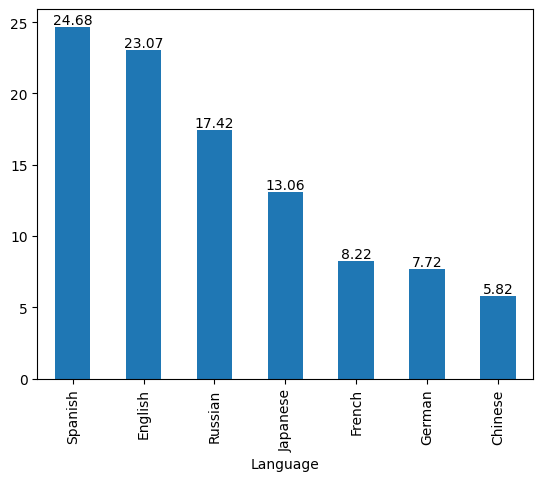

In [ ]:
Lg.plot(kind="bar")
for i, count in enumerate(round(Lg,2)):
    plt.text(i, count, str(count), ha='center', va='bottom')

##3.2 Dickey fuller test

In [14]:
import statsmodels.api as sm

In [ ]:
for col in data_TimeSeries.columns:
    pvalue = sm.tsa.stattools.adfuller(data_TimeSeries[col])[1]
    if pvalue >= 0.05:
        print(col,": Sequence is not stationary")
    else:
        print(col, ": Sequence is stationary")

Chinese : Sequence is not stationary
English : Sequence is not stationary
French : Sequence is not stationary
German : Sequence is not stationary
Japanese : Sequence is not stationary
Russian : Sequence is not stationary
Spanish : Sequence is not stationary


In [15]:
def adf_test(lange,data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1]
    if pvalue <= significance_level:
        print(lange,'Sequence is stationary')
    else:
        print(lange,'Sequence is not stationary')

#3.3 Decomposition

##Decomposition: time-series data "English"

In [ ]:
model_decompose = sm.tsa.seasonal_decompose(data_TimeSeries["English"], model='additive')

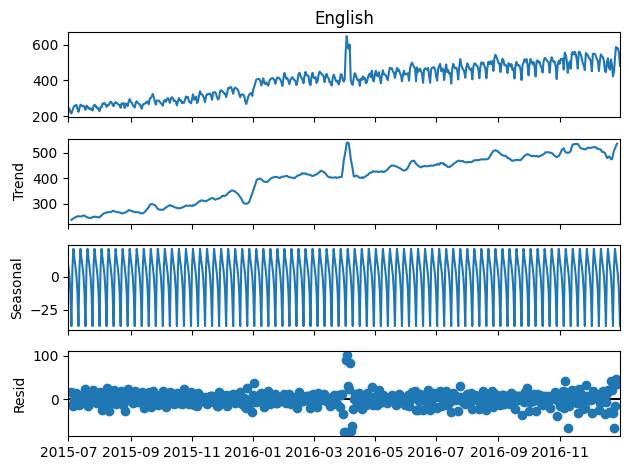

In [ ]:
temp = model_decompose.plot()

<Axes: >

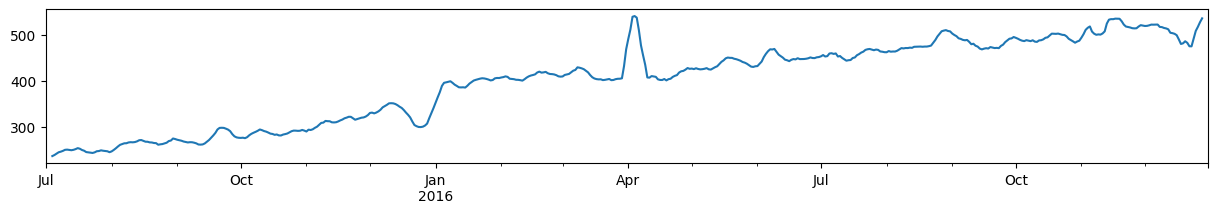

In [ ]:
model_decompose.trend.plot(figsize=(15,2))

<Axes: >

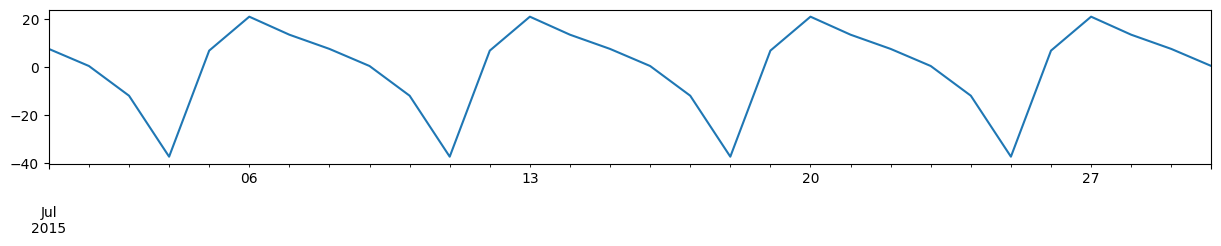

In [ ]:
model_decompose.seasonal[:30].plot(figsize=(15,2))

<Axes: ylabel='Density'>

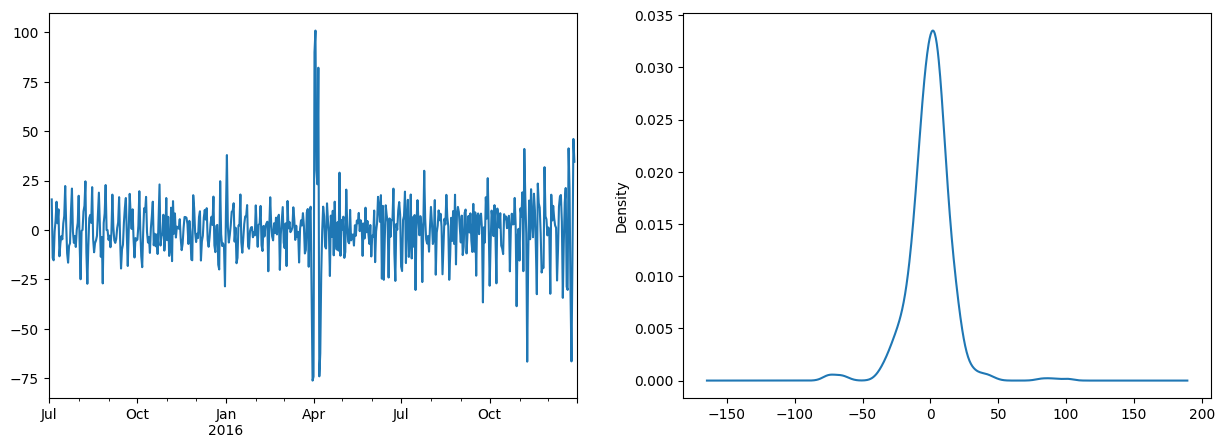

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
model_decompose.resid.plot()
plt.subplot(1,2,2)
model_decompose.resid.plot(kind="kde")

In [16]:
lang = list(data_TimeSeries.columns)

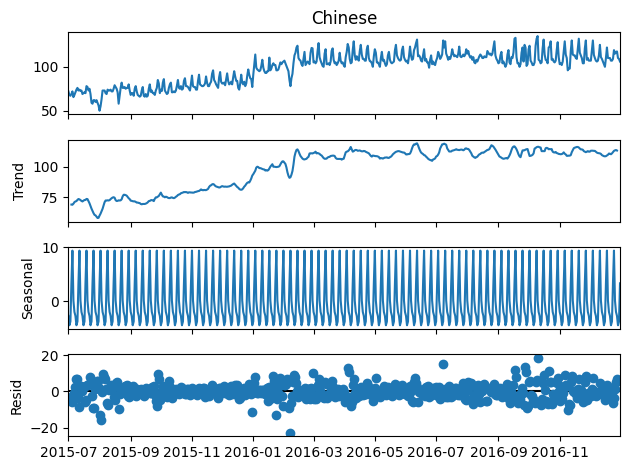

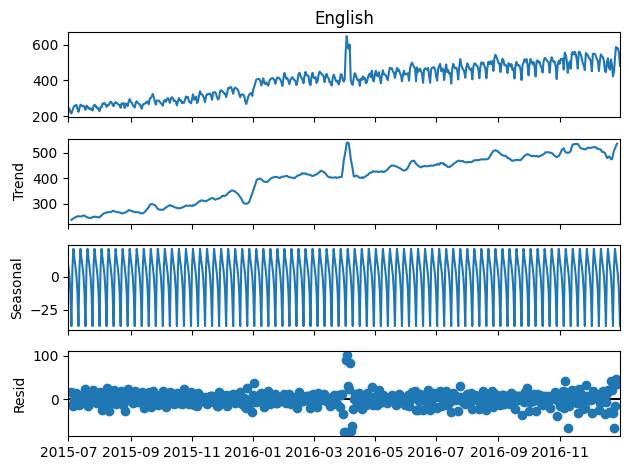

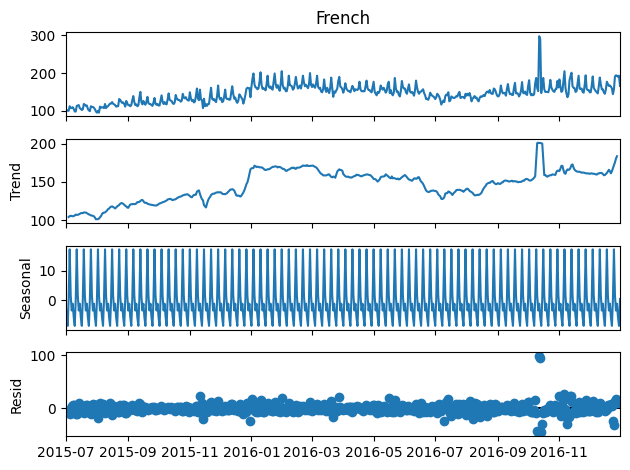

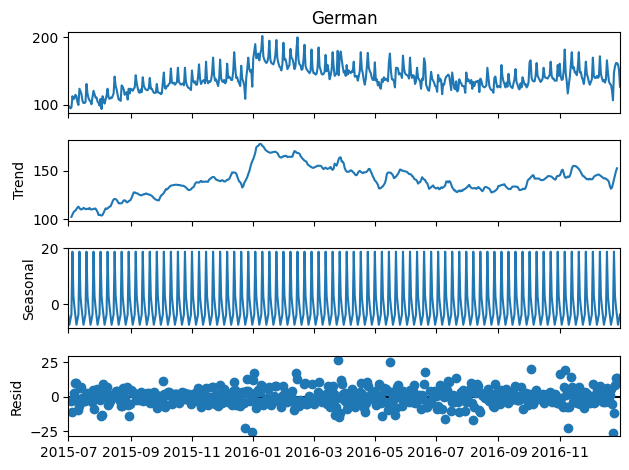

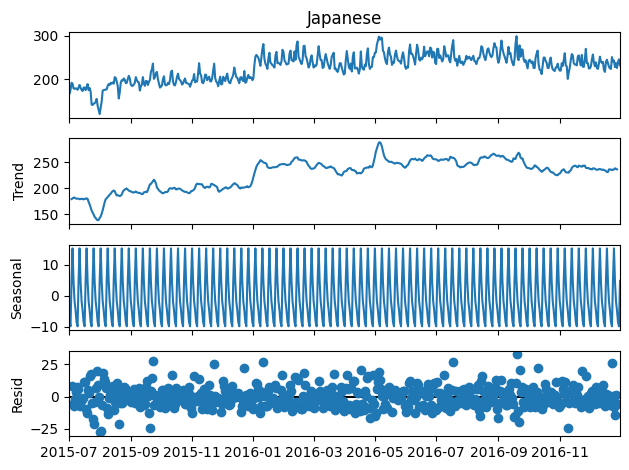

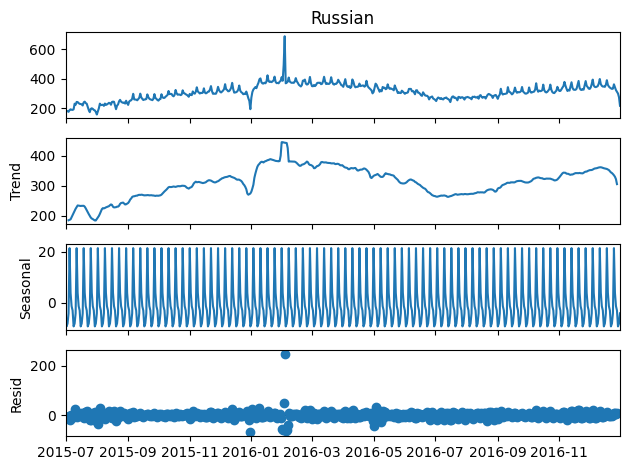

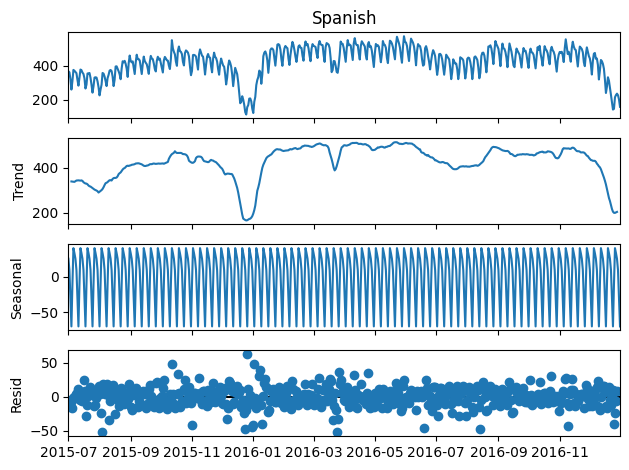

In [ ]:
#decomposition of all the language
for i in range(len(lang)):
  model_decompose = sm.tsa.seasonal_decompose(data_TimeSeries[lang[i]], model='additive')
  model_decompose.plot()

##3.4 Differencing: time-series data "English"

<Axes: >

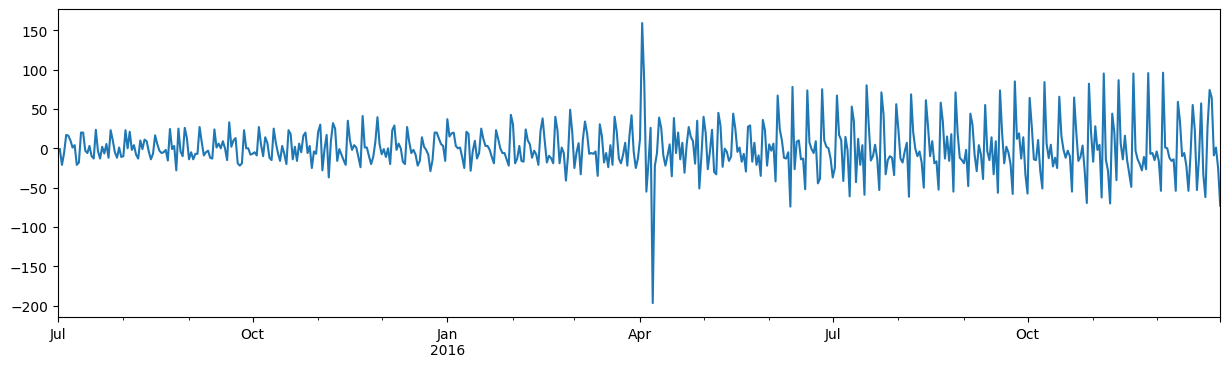

In [ ]:
data_TimeSeries["English"].diff().plot(figsize=(15,4))
##trend

In [ ]:
for i in range(len(lang)):
    adf_test(lang[i],data_TimeSeries[lang[i]].diff().dropna())

Chinese Sequence is stationary
English Sequence is stationary
French Sequence is stationary
German Sequence is stationary
Japanese Sequence is stationary
Russian Sequence is stationary
Spanish Sequence is stationary


#4. Creating model training and forecasting with ARIMA, SARIMAX

##4.1 Plotting the ACF and PACF plots

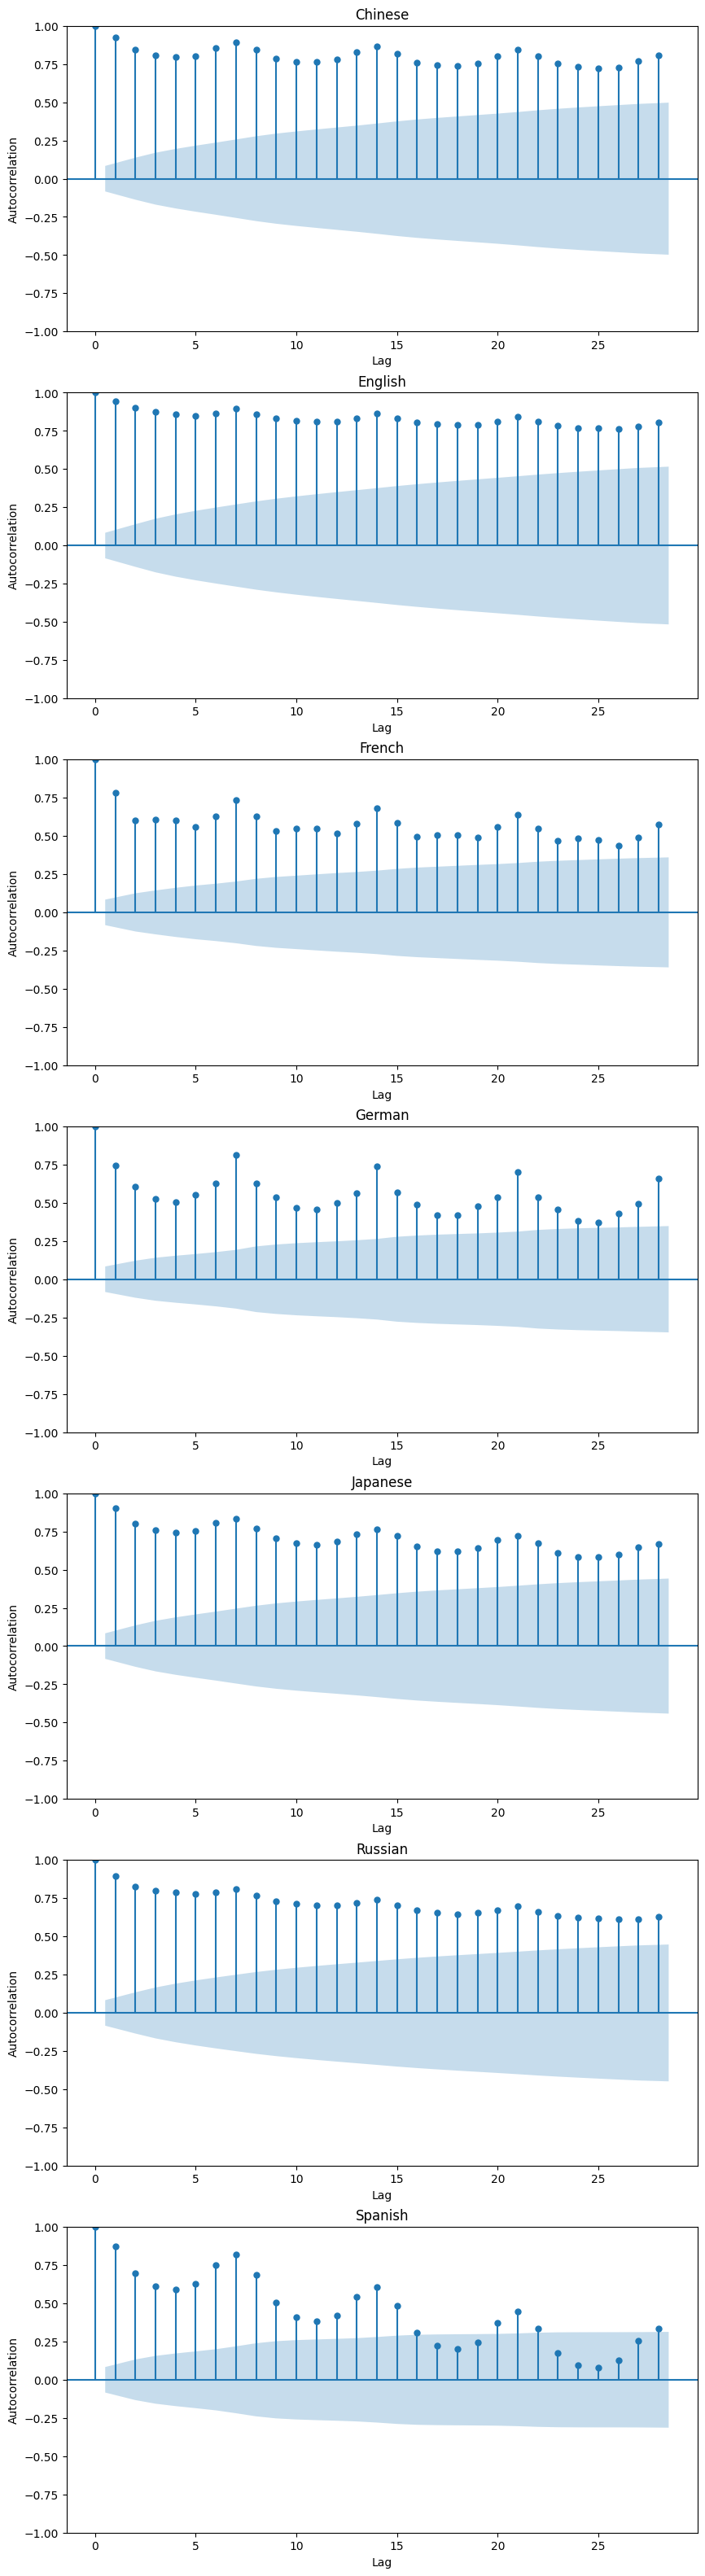

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF
fig, axs = plt.subplots(7,1,figsize=(10, 40))
for i in range(len(lang)):
  plot_acf(data_TimeSeries[lang[i]], ax=axs[i])
  # Label the axes
  axs[i].set_xlabel('Lag')
  axs[i].set_ylabel('Autocorrelation')
  axs[i].set_title(lang[i])
# Show the plot
plt.show()

From the ACF plot the seasonality seems to be 7

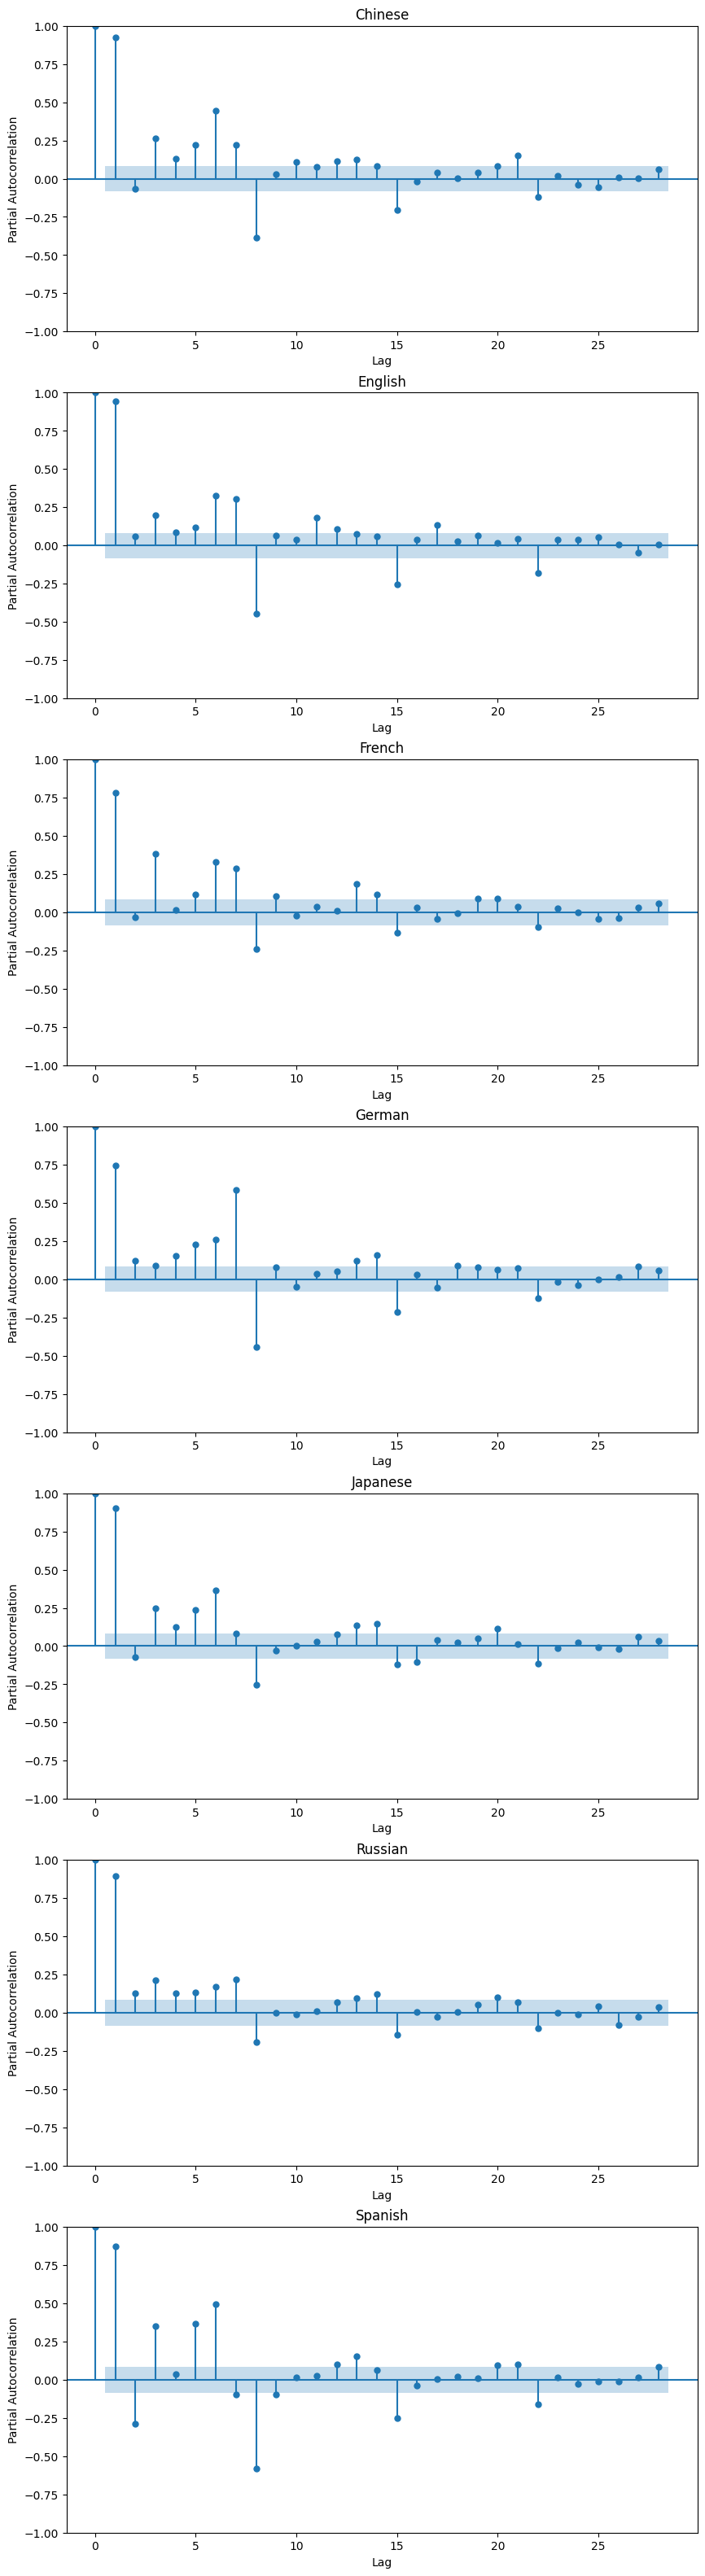

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the PACF
fig, axs = plt.subplots(7,1,figsize=(10, 40))
for i in range(len(lang)):
  plot_pacf(data_TimeSeries[lang[i]], lags = None,ax=axs[i])
  # Label the axes
  axs[i].set_xlabel('Lag')
  axs[i].set_ylabel('Partial Autocorrelation')
  axs[i].set_title(lang[i])
# Show the plot
plt.show()

From the PACF plot the seasonality seems to be 7

##4.2 Training the model.

##Train-Test-Split

In [20]:
data_TimeSeries.head()

Language,Chinese,English,French,German,Japanese,Russian,Spanish,Exog
2015-07-01,72.0,243.0,101.0,99.0,172.0,180.0,368.0,0
2015-07-02,68.0,242.0,102.0,97.0,167.0,183.0,362.0,0
2015-07-03,67.0,221.0,100.0,95.0,176.0,182.0,322.0,0
2015-07-04,69.0,215.0,100.0,96.0,192.0,177.0,261.0,0
2015-07-05,72.0,232.0,112.0,113.0,190.0,189.0,311.0,0


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [19]:
train_x = data_TimeSeries.loc[data_TimeSeries.index[:-61]]

In [20]:
test_x = data_TimeSeries.loc[data_TimeSeries.index[-61:]]

In [21]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
  print('MAE :', round(mae(actual, predicted), 3))
  print('RMSE :', round(mse(actual, predicted)**0.5, 3))
  print('MAPE:', round(mape(actual, predicted), 3))
  #return(round(mae(actual, predicted),3),round(mse(actual, predicted)**0.5,3),round(mape(actual, predicted), 3))

##4.2.1 ARIMA model

In [ ]:
train_x["English"].head()

2015-07-01    243.0
2015-07-02    242.0
2015-07-03    221.0
2015-07-04    215.0
2015-07-05    232.0
Name: English, dtype: float64

In [ ]:
adf_test("English",train_x["English"])

English Sequence is not stationary


In [ ]:
adf_test("English",train_x["English"].diff(1).dropna())

English Sequence is stationary


In [22]:
pred = pd.DataFrame(index=test_x.index)

##grid search

In [ ]:
ar = [8,9,10]
ma = [4,5,6]
result = []
for p in ar:
    for q in ma:
        model_temp = SARIMAX(train_x["English"], order=(p, 1, q))
        model_temp = model_temp.fit(disp=False)
        result.append([p,q,round(mape(test_x["English"], model_temp.forecast(steps=61)), 3)])
result1 = pd.DataFrame(result, columns=["p","q","mape"]).sort_values(by="mape",ascending=True).iloc[0,0:2]
model_ARIMA = SARIMAX(train_x["English"], order=(result1[0], 1, result1[1]))
model_ARIMA = model_ARIMA.fit(disp=False)
pred["English"] = model_ARIMA.forecast(steps=61)

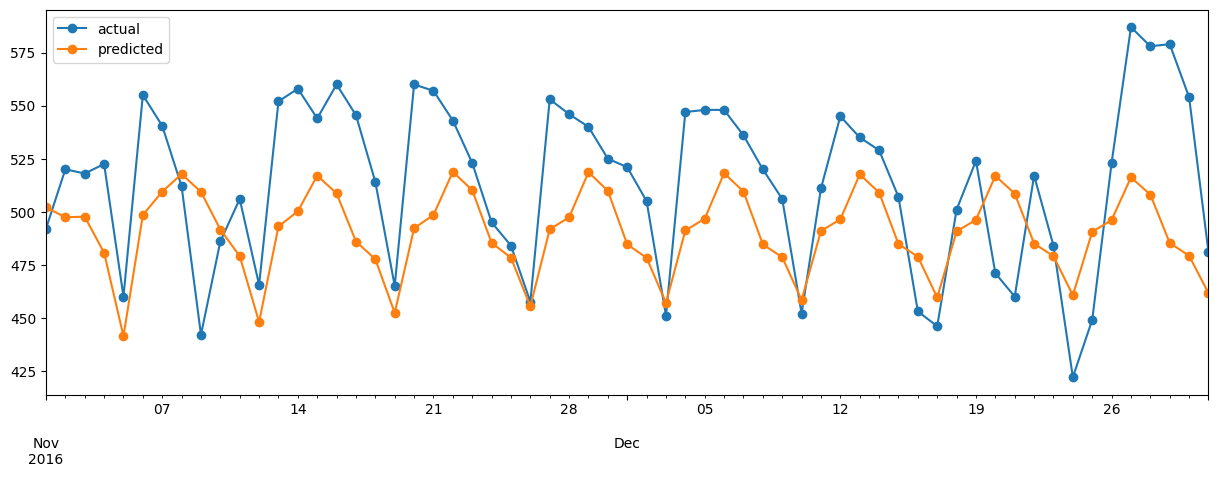

In [ ]:
test_x["English"].plot(style="-o",figsize=(15,5), label="actual")
pred["English"].plot(style="-o",label="predicted")
plt.legend()

In [79]:
performance(test_x["English"], pred["English"])

MAE : 25.959
RMSE : 34.745
MAPE: 0.053


In [ ]:
#Forecasting with ARIMA for 7 different langauges
print("  Language   |MAE    |RMS    |MAPE")
print("--"*20);
d = []
for i in range(len(lang)):
  model_ARIMA = SARIMAX(train_x[lang[i]], order=(9, 1, 5))
  model_ARIMA = model_ARIMA.fit(disp=False)
  pred[lang[i]] = model_ARIMA.forecast(steps=61)
  print(i+1,lang[i]," |",performance(test_x[lang[i]], pred[lang[i]])[0]," |",performance(test_x[lang[i]], pred[lang[i]])[1]," |",performance(test_x[lang[i]], pred[lang[i]])[2])
  d.append(performance(test_x[lang[i]], pred[lang[i]])[2])

  Language   |MAE    |RMS    |MAPE
----------------------------------------
1 Chinese  | 4.55  | 5.717  | 0.041
2 English  | 33.423  | 39.704  | 0.064
3 French  | 13.346  | 16.541  | 0.079
4 German  | 9.952  | 13.338  | 0.067
5 Japanese  | 11.004  | 13.824  | 0.045
6 Russian  | 27.686  | 33.206  | 0.081
7 Spanish  | 79.917  | 107.26  | 0.304


In [23]:
import warnings
warnings.filterwarnings('ignore')

##Pipeline for working with all language in case of ARIMA and its performance metric

In [30]:
ar = [9,10,11]
ma = [5,6,7]
for i in range(len(lang)):
  result = []
  for p in ar:
      for q in ma:
          model_temp = SARIMAX(train_x[lang[i]], order=(p, 1, q))
          model_temp = model_temp.fit(disp=False)
          result.append([p,q,round(mape(test_x[lang[i]], model_temp.forecast(steps=61)), 3)])
  result1 = pd.DataFrame(result, columns=["p","q","mape"]).sort_values(by="mape",ascending=True).iloc[0,0:2]
  print("For language", lang[i]," p =",result1[0]," q =",result1[1])
  model_ARIMA = SARIMAX(train_x[lang[i]], order=(result1[0], 1, result1[1]))
  model_ARIMA = model_ARIMA.fit(disp=False)
  pred[lang[i]] = model_ARIMA.forecast(steps=61)
  print("Performance of ",lang[i],"is " )
  performance(test_x[lang[i]], pred[lang[i]])

For language Chinese  p = 10.0  q = 6.0
Performance of  Chinese is 
MAE : 4.006
RMSE : 5.104
MAPE: 0.036
For language English  p = 10.0  q = 7.0
Performance of  English is 
MAE : 32.428
RMSE : 37.763
MAPE: 0.062
For language French  p = 9.0  q = 6.0
Performance of  French is 
MAE : 12.129
RMSE : 15.807
MAPE: 0.071
For language German  p = 9.0  q = 7.0
Performance of  German is 
MAE : 9.174
RMSE : 12.108
MAPE: 0.062
For language Japanese  p = 11.0  q = 5.0
Performance of  Japanese is 
MAE : 8.267
RMSE : 11.237
MAPE: 0.034
For language Russian  p = 10.0  q = 5.0
Performance of  Russian is 
MAE : 25.545
RMSE : 32.813
MAPE: 0.075
For language Spanish  p = 9.0  q = 7.0
Performance of  Spanish is 
MAE : 81.233
RMSE : 102.269
MAPE: 0.292


* From the above code, we can conclude that p = 9, q = 7

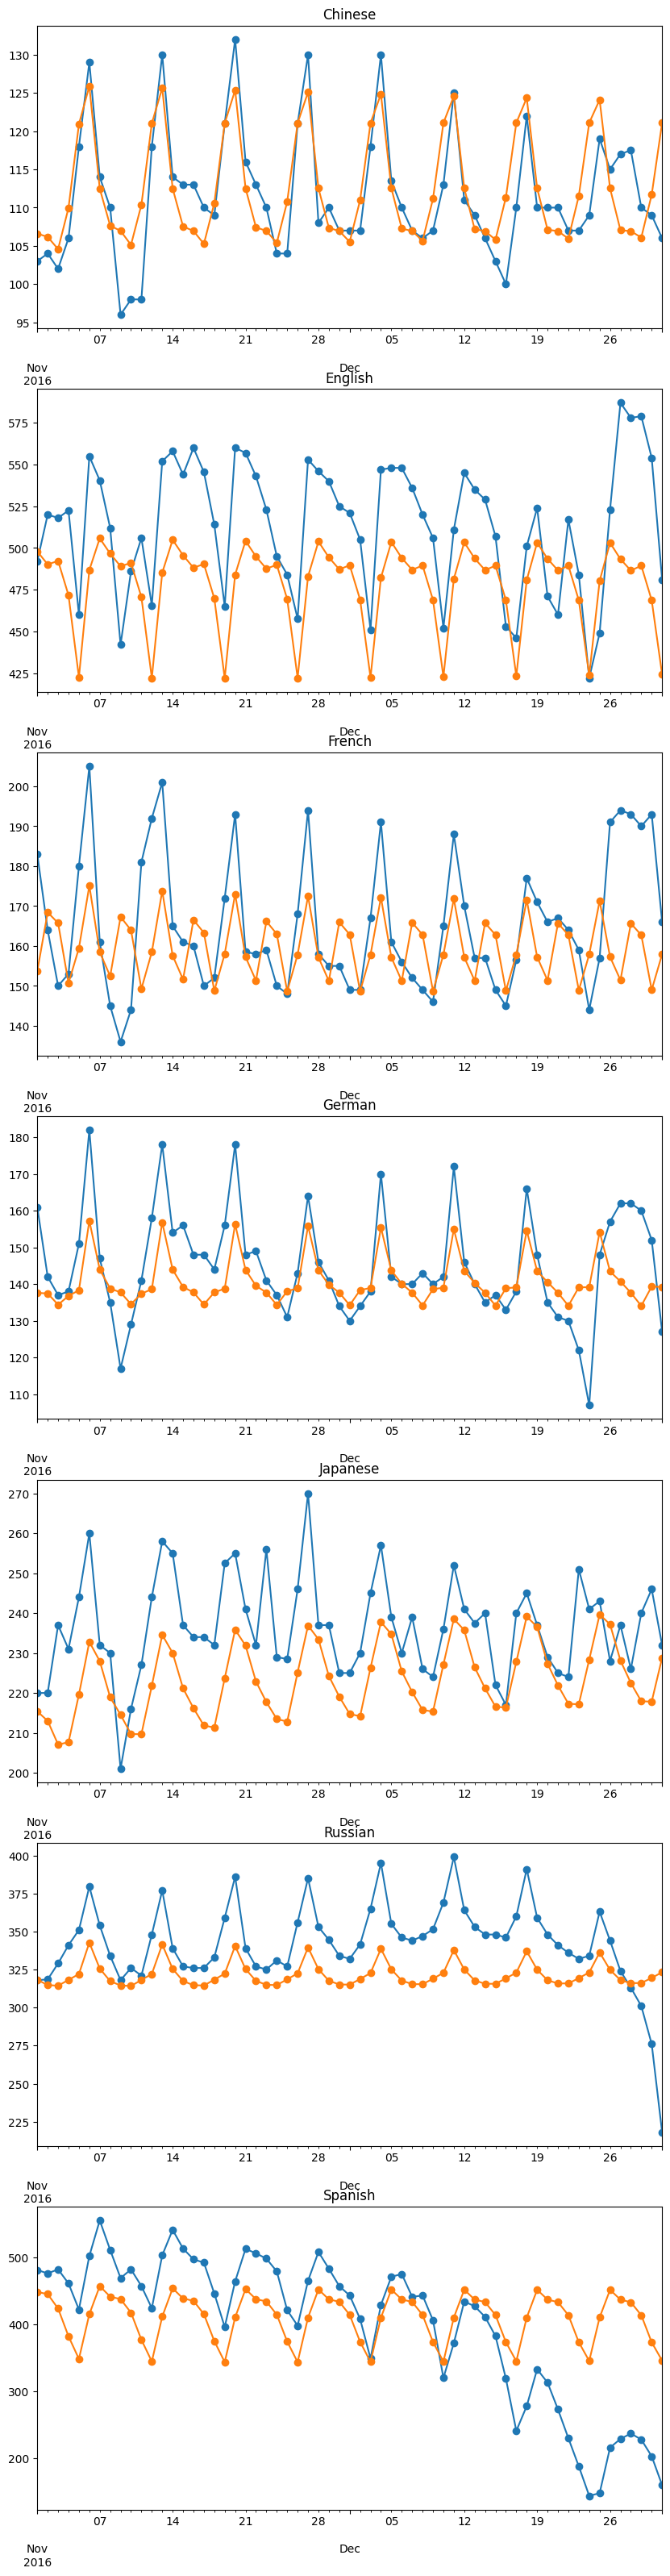

In [31]:
fig, axs = plt.subplots(7,1,figsize=(10,40))
for i in range(len(lang)):
  model_ARIMA = SARIMAX(train_x[lang[i]], order=(9, 1, 7))
  model_ARIMA = model_ARIMA.fit(disp=False)
  pred[lang[i]] = model_ARIMA.forecast(steps=61)
  test_x[lang[i]].plot(style="-o",label="actual",ax=axs[i])
  pred[lang[i]].plot(style="-o",label="predicted",ax=axs[i])
  axs[i].set_title(lang[i])
plt.show()

##4.2.2 SARIMA model

##Pipeline for working with all language in case of SARIMA and its performance metric

In [32]:
for i in range(len(lang)):
  model_SARIMA = SARIMAX(train_x[lang[i]], order=(9, 1, 7),seasonal_order=(1,1,1,12))
  model_SARIMA = model_SARIMA.fit(disp=False)
  pred[lang[i]] = model_SARIMA.forecast(steps=61)
  print("Performance of ",lang[i],"is " )
  performance(test_x[lang[i]], pred[lang[i]])

Performance of  Chinese is 
MAE : 4.668
RMSE : 5.834
MAPE: 0.043
Performance of  English is 
MAE : 30.146
RMSE : 39.148
MAPE: 0.061
Performance of  French is 
MAE : 12.546
RMSE : 15.907
MAPE: 0.076
Performance of  German is 
MAE : 9.269
RMSE : 11.916
MAPE: 0.064
Performance of  Japanese is 
MAE : 16.799
RMSE : 20.143
MAPE: 0.072
Performance of  Russian is 
MAE : 19.097
RMSE : 26.982
MAPE: 0.058
Performance of  Spanish is 
MAE : 80.541
RMSE : 110.725
MAPE: 0.309


##4.2.3 SARIMAX model

##Getting the exogenous variable and using it to train a sarimax model

In [ ]:
data_TimeSeries["Exog"]=df["Exog"].values

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
ar_seasonal = [2,3]
ma_seasonal = [2,3]
result = []
exog_forecast = test_x[['Exog']]
for P in ar_seasonal:
  for Q in ma_seasonal:
    model = SARIMAX(train_x['English'], exog=train_x['Exog'],order=(9,1,7),seasonal_order=(P,1,Q,12))
    model = model.fit(disp=False)
    predictions_ = model.predict(start=test_x.index[0], end=test_x.index[-1], exog=exog_forecast).rename('Predictions')
    result.append([P,Q,round(mape(test_x['English'], predictions_), 3)])
result1 = pd.DataFrame(result, columns=["p","q","mape"]).sort_values(by="mape",ascending=True).iloc[0,0:2]
print("For English language, P =",result1[0]," Q =",result1[1])

For English language, P = 2.0  Q = 3.0


##Pipeline for working with all language in case of SARIMAX and its performance metric

In [35]:
for i in range(len(lang)):
  model_SARIMAX = SARIMAX(train_x[lang[i]], exog=train_x['Exog'],order=(9, 1,7),seasonal_order=(2,1,3,12))
  model_SARIMAX = model_SARIMAX.fit(disp=False)
  pred[lang[i]] = model_SARIMAX.predict(start=test_x.index[0], end=test_x.index[-1], exog=exog_forecast).rename('Predictions')
  print("Performance of ",lang[i],"is " )
  performance(test_x[lang[i]], pred[lang[i]])

Performance of  Chinese is 
MAE : 4.514
RMSE : 5.526
MAPE: 0.041
Performance of  English is 
MAE : 25.959
RMSE : 34.745
MAPE: 0.053
Performance of  French is 
MAE : 13.282
RMSE : 17.804
MAPE: 0.078
Performance of  German is 
MAE : 9.406
RMSE : 12.155
MAPE: 0.065
Performance of  Japanese is 
MAE : 16.836
RMSE : 19.941
MAPE: 0.072
Performance of  Russian is 
MAE : 18.726
RMSE : 26.7
MAPE: 0.057
Performance of  Spanish is 
MAE : 75.725
RMSE : 94.918
MAPE: 0.269


In [36]:
model = SARIMAX(train_x["English"], exog=train_x['Exog'], order=(9,1,7),seasonal_order=(2,1,3,12))
model = model.fit(disp=False)
exog_forecast = test_x[['Exog']]
predictions = model.predict(start=test_x.index[0], end=test_x.index[-1], exog=exog_forecast).rename('Predictions')

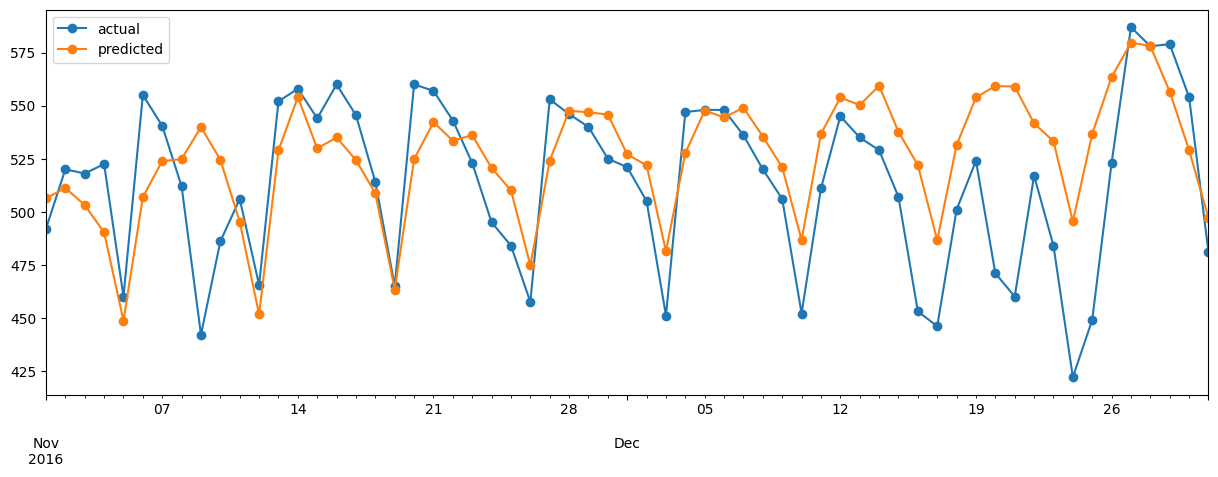

In [37]:
test_x["English"].plot(style="-o",figsize=(15,5), label="actual")
predictions.plot(style="-o",label="predicted")
plt.legend()

In [38]:
performance(test_x["English"], predictions)

MAE : 25.959
RMSE : 34.745
MAPE: 0.053


##confidence interval - 95%

In [39]:
model.get_forecast(steps=61, exog=exog_forecast).conf_int(0.05).values[:5]

array([[459.1941347 , 553.44190034],
       [452.51775972, 569.87694517],
       [435.95373978, 570.32065894],
       [416.44133737, 564.16337655],
       [368.47748657, 528.79011961]])

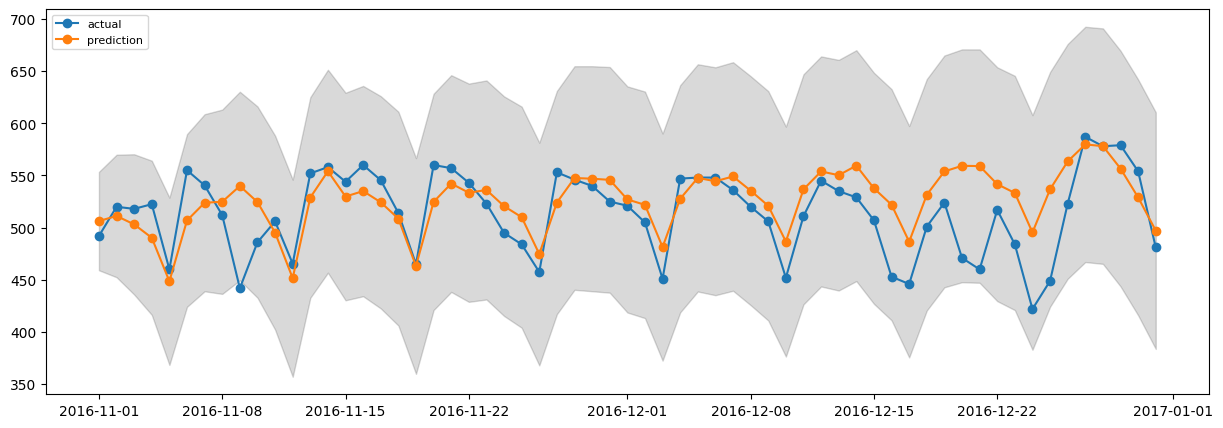

In [40]:
test_x[['lower', 'upper']] = model.get_forecast(steps=61, exog=exog_forecast).conf_int(0.1).values

plt.figure(figsize=(15,5))
plt.plot(test_x['English'], '-o', label='actual')
plt.plot(predictions, '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'],color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

##5. Forecasting with Facebook prophet

* Use facebook prophet for forecasting

In [41]:
from prophet import Prophet

In [42]:
df_new = data_TimeSeries.reset_index().loc[:,["index","English","Exog"]].rename(columns={"index":"ds","English":"y","Exog":"holiday"})
df_new.head()

Language,ds,y,holiday
0,2015-07-01,243.0,0
1,2015-07-02,242.0,0
2,2015-07-03,221.0,0
3,2015-07-04,215.0,0
4,2015-07-05,232.0,0


##fbprophet without exog data

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/eiln2ckc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/kr0_mlqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58134', 'data', 'file=/tmp/tmp8389irwy/eiln2ckc.json', 'init=/tmp/tmp8389irwy/kr0_mlqo.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelptik73fi/prophet_model-20231212155521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


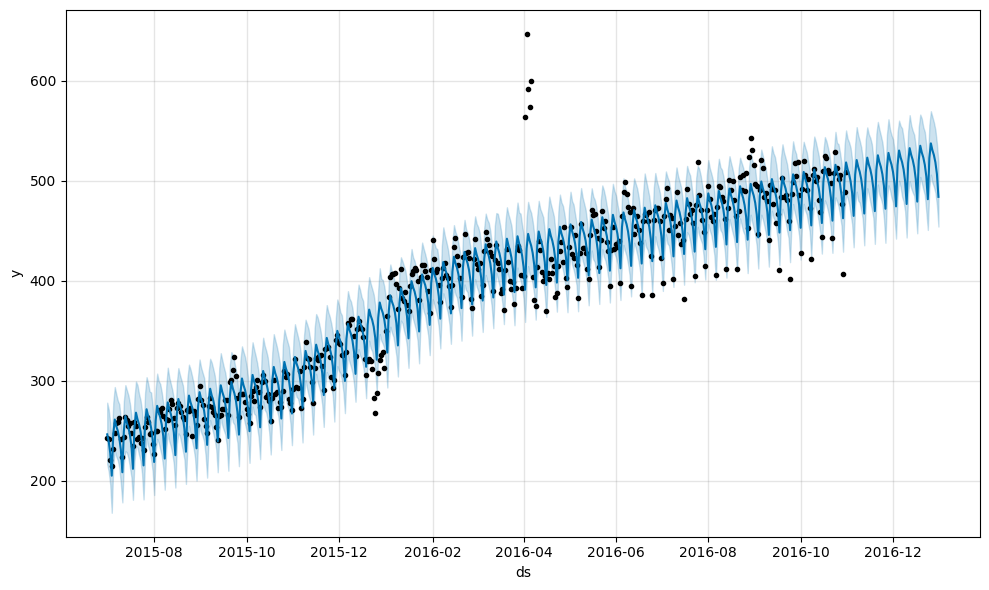

In [45]:
m = Prophet()
m.fit(df_new.loc[:,["ds","y"]][:-61])
future = m.make_future_dataframe(periods=61, freq='D')
forecast = m.predict(future)
m.plot(forecast);

In [46]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [47]:
forecast["yhat"].head()

0    246.340888
1    239.147600
2    227.633260
3    204.991356
4    246.350247
Name: yhat, dtype: float64

In [48]:
forecast["yhat"].shape

(550,)

In [49]:
pd.concat([df_new,forecast[["yhat"]]], axis=1).tail()

,ds,y,holiday,yhat
545,2016-12-27,587.0,1,530.746235
546,2016-12-28,578.0,1,525.786535
547,2016-12-29,579.0,1,518.444791
548,2016-12-30,554.0,0,506.781996
549,2016-12-31,481.0,0,483.991635


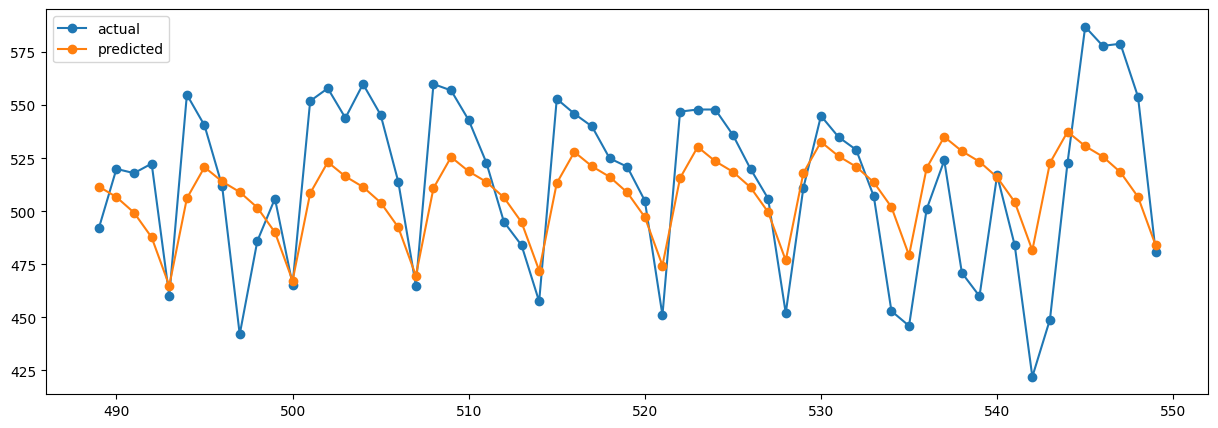

In [50]:
df_new["y"][-61:].plot(style="-o",figsize=(15,5), label="actual")
forecast["yhat"][-61:].plot(style="-o",label="predicted")
plt.legend()

In [51]:
performance(df_new["y"][-61:], forecast["yhat"][-61:])

MAE : 25.565
RMSE : 31.885
MAPE: 0.05


##Pipeline for working with all language in case of Facebook prophet and its performance metric

In [72]:
for i in range(len(lang)):
  df_new = data_TimeSeries.reset_index().loc[:,["index",lang[i],"Exog"]].rename(columns={"index":"ds",lang[i]:"y","Exog":"holiday"})
  m1 = Prophet()
  m1.fit(df_new.loc[:,["ds","y"]][:-61])
  future = m1.make_future_dataframe(periods=61, freq='D')
  forecast = m1.predict(future)
  print("Performance of ",lang[i],"is " )
  performance(df_new["y"][-61:], forecast["yhat"][-61:])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/psm_v55i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/mcg_ynop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3206', 'data', 'file=/tmp/tmp8389irwy/psm_v55i.json', 'init=/tmp/tmp8389irwy/mcg_ynop.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelmw7tsiez/prophet_model-20231212161807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

Performance of  Chinese is 
MAE : 4.332
RMSE : 5.475
MAPE: 0.04


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/y1m4htzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/8bjs5ika.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80684', 'data', 'file=/tmp/tmp8389irwy/y1m4htzz.json', 'init=/tmp/tmp8389irwy/8bjs5ika.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modellox2heog/prophet_model-20231212161808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  English is 
MAE : 25.565
RMSE : 31.885
MAPE: 0.05


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/8lqa9q24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/4tj_su7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51880', 'data', 'file=/tmp/tmp8389irwy/8lqa9q24.json', 'init=/tmp/tmp8389irwy/4tj_su7n.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelysp4mp7c/prophet_model-20231212161808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  French is 
MAE : 14.35
RMSE : 16.283
MAPE: 0.089


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/168ijp3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/qrdajnen.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56187', 'data', 'file=/tmp/tmp8389irwy/168ijp3_.json', 'init=/tmp/tmp8389irwy/qrdajnen.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelw1j445i6/prophet_model-20231212161808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  German is 
MAE : 8.825
RMSE : 11.565
MAPE: 0.061


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/yx4te7wl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/jcj0p9hp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12301', 'data', 'file=/tmp/tmp8389irwy/yx4te7wl.json', 'init=/tmp/tmp8389irwy/jcj0p9hp.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelpjm3gvd1/prophet_model-20231212161809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  Japanese is 
MAE : 6.716
RMSE : 9.687
MAPE: 0.029


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/ylm27oe5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/7mx6nnss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37325', 'data', 'file=/tmp/tmp8389irwy/ylm27oe5.json', 'init=/tmp/tmp8389irwy/7mx6nnss.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modeljt3enn3r/prophet_model-20231212161809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  Russian is 
MAE : 16.397
RMSE : 26.786
MAPE: 0.052
Performance of  Spanish is 
MAE : 75.066
RMSE : 111.321
MAPE: 0.302


##fbprophet with exog data

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/ts8_v70w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/fla6wwcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45559', 'data', 'file=/tmp/tmp8389irwy/ts8_v70w.json', 'init=/tmp/tmp8389irwy/fla6wwcb.json', 'output', 'file=/tmp/tmp8389irwy/prophet_model8gvccf96/prophet_model-20231212161848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


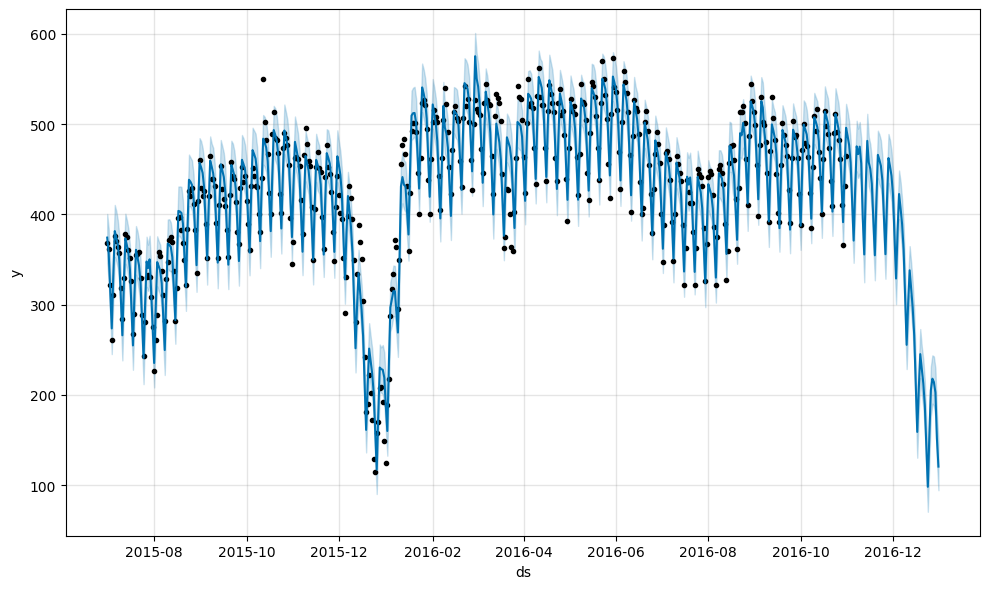

In [73]:
model2=Prophet(yearly_seasonality=True, weekly_seasonality=True)
model2.add_regressor('holiday') #adding holidays data in the model2
model2.fit(df_new[:-61])
forecast2 = model2.predict(df_new)
fig = model2.plot(forecast2)

In [74]:
forecast2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,368.967306,346.330843,400.595158,368.967306,368.967306,5.379583,5.379583,5.379583,0.0,...,26.878263,26.878263,26.878263,-21.498680,-21.498680,-21.498680,0.0,0.0,0.0,374.346889
1,2015-07-02,369.296417,325.711911,383.973623,369.296417,369.296417,-12.928701,-12.928701,-12.928701,0.0,...,10.252001,10.252001,10.252001,-23.180702,-23.180702,-23.180702,0.0,0.0,0.0,356.367716


In [75]:
forecast2.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'holiday', 'holiday_lower',
       'holiday_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [55]:
forecast2["yhat"].head()

0    252.682206
1    244.857178
2    232.632618
3    209.372224
4    250.169668
Name: yhat, dtype: float64

In [56]:
forecast2["yhat"].shape

(550,)

In [57]:
pd.concat([df_new,forecast2[["yhat"]]], axis=1).tail()

,ds,y,holiday,yhat
545,2016-12-27,587.0,1,557.186370
546,2016-12-28,578.0,1,554.339795
547,2016-12-29,579.0,1,549.848352
548,2016-12-30,554.0,0,530.420568
549,2016-12-31,481.0,0,511.162859


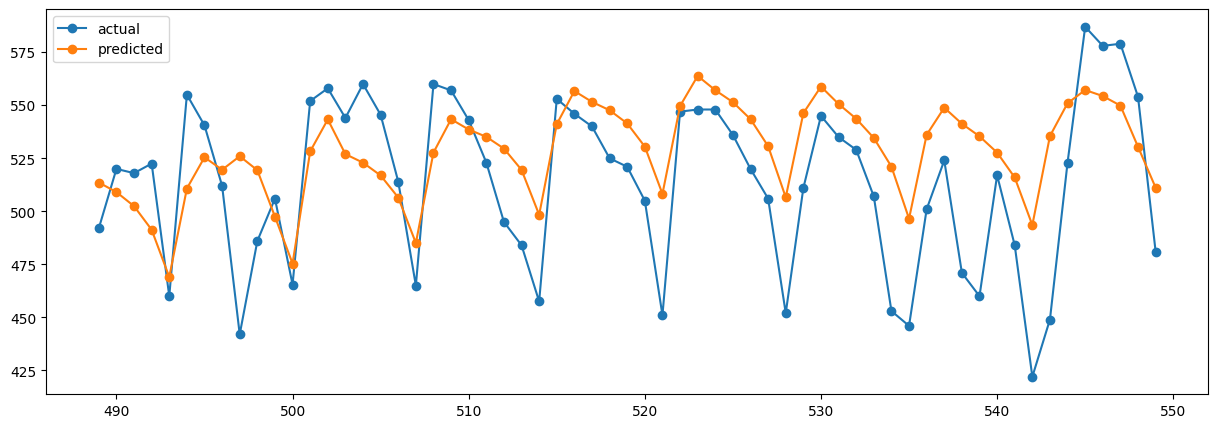

In [58]:
df_new["y"][-61:].plot(style="-o",figsize=(15,5), label="actual")
forecast2["yhat"][-61:].plot(style="-o",label="predicted")
plt.legend()

In [59]:
performance(df_new["y"][-61:], forecast2["yhat"][-61:])

MAE : 28.114
RMSE : 34.416
MAPE: 0.057


In [76]:
for i in range(len(lang)):
  df_new = data_TimeSeries.reset_index().loc[:,["index",lang[i],"Exog"]].rename(columns={"index":"ds",lang[i]:"y","Exog":"holiday"})
  model2=Prophet(yearly_seasonality=True, weekly_seasonality=True)
  model2.add_regressor('holiday') #adding holidays data in the model2
  model2.fit(df_new[:-61])
  forecast2 = model2.predict(df_new)
  print("Performance of ",lang[i],"is " )
  performance(df_new["y"][-61:], forecast["yhat"][-61:])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/0fcn1906.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/3gayygwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69903', 'data', 'file=/tmp/tmp8389irwy/0fcn1906.json', 'init=/tmp/tmp8389irwy/3gayygwg.json', 'output', 'file=/tmp/tmp8389irwy/prophet_model0vecq4lc/prophet_model-20231212162210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83

Performance of  Chinese is 
MAE : 333.93
RMSE : 336.273
MAPE: 3.014


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/7y9yw6hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/llp66r08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19475', 'data', 'file=/tmp/tmp8389irwy/7y9yw6hu.json', 'init=/tmp/tmp8389irwy/llp66r08.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelxxe4nilr/prophet_model-20231212162211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  English is 
MAE : 69.699
RMSE : 75.903
MAPE: 0.135


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/jezuxov8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/f3tr131b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2086', 'data', 'file=/tmp/tmp8389irwy/jezuxov8.json', 'init=/tmp/tmp8389irwy/f3tr131b.json', 'output', 'file=/tmp/tmp8389irwy/prophet_model7ckb1fjb/prophet_model-20231212162211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  French is 
MAE : 280.176
RMSE : 283.4
MAPE: 1.723


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/z9dwwn44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/q4q4qeef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94266', 'data', 'file=/tmp/tmp8389irwy/z9dwwn44.json', 'init=/tmp/tmp8389irwy/q4q4qeef.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelj61x73z_/prophet_model-20231212162212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  German is 
MAE : 300.34
RMSE : 302.849
MAPE: 2.095


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/78shei8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/f9q1mdpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55100', 'data', 'file=/tmp/tmp8389irwy/78shei8s.json', 'init=/tmp/tmp8389irwy/f9q1mdpz.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelsyh5df6z/prophet_model-20231212162212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  Japanese is 
MAE : 209.118
RMSE : 213.342
MAPE: 0.891


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/owsqjtgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8389irwy/r15v_jy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90025', 'data', 'file=/tmp/tmp8389irwy/owsqjtgr.json', 'init=/tmp/tmp8389irwy/r15v_jy9.json', 'output', 'file=/tmp/tmp8389irwy/prophet_modelr3k1gbpf/prophet_model-20231212162212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance of  Russian is 
MAE : 103.364
RMSE : 113.584
MAPE: 0.311
Performance of  Spanish is 
MAE : 75.066
RMSE : 111.321
MAPE: 0.302


#Inferences and recommendations


##Questionnaire:

* Defining the problem statements and where can this and modifications of this be used?
  * You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

  * Dataset:
https://drive.google.com/drive/folders/1mdgQscjqnCtdg7LGItomyK0abN6lcHBb

    There are two csv files given

    * train_1.csv: In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

      The page name contains data in this format:

      SPECIFIC NAME _ LANGUAGE.wikipedia.org _ACCESS TYPE_ACCESS ORIGIN

      having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

    * Exog_Campaign_eng: This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

      There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

* Write 3 inferences you made from the data visualizations

  1. English and Spanish have the higher median values
  2. Chinese has the lowest median value
  3. All Access type has the highest percentage of access type which is more than 50 %
  4. All agents access origin has the highest percentage of acess origin type of above 75 %

* What does the decomposition of series do?
  * The decomposition of a time series involves breaking it down into its individual components. Namely : Trends, Seasonality

    * Trend: The long-term movement or direction in the time series. It represents the underlying pattern that shows whether the series is generally increasing, decreasing, or stable over time.

    * Seasonality: The repeating, periodic fluctuations in the time series that occur with a fixed frequency. For example, language "English have a seasonal pattern

    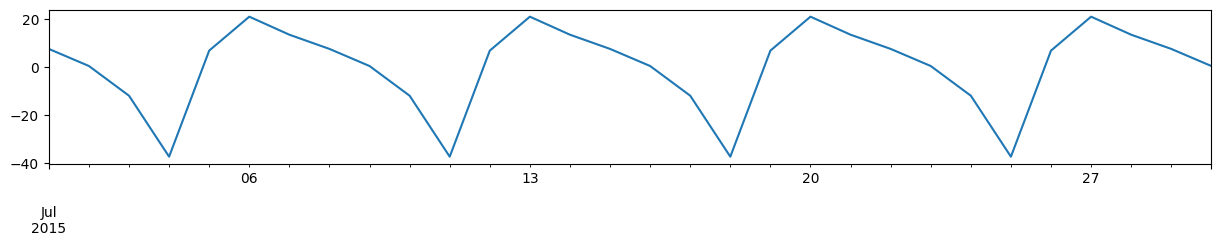
    * Cycle: The longer-term undulating pattern in the time series that is not strictly tied to a fixed frequency. Cycles are often associated with economic or business cycles and can have varying durations.
    * Residuals (or Irregular Component):The remaining variability in the time series that cannot be explained by the trend, seasonality, or cycle. It includes random fluctuations, noise, and any irregular patterns.

* What level of differencing gave you a stationary series?
  * Single level of differencing gaves a stationary series

* Difference between arima, sarima & sarimax.
  * For English Language
  * **ARIMA**
    * MAE : 25.959
    * RMSE : 34.745
    * MAPE: 0.053
  * **SARIMA**
    * MAE : 30.146
    * RMSE : 39.148
    * MAPE: 0.061
  * **SARIMAX**
    * MAE : 25.959
    * RMSE : 34.745
    * MAPE: 0.053
  * **Facebook prophet without Exog**
    * MAE : 25.565
    * RMSE : 31.885
    * MAPE: 0.05
  * **Facebook prophet with Exog**
    * MAE : 28.114
    * RMSE : 34.416
    * MAPE: 0.057
  The MAPE is in the range of 5-6%

* Compare the number of views in different languages
  The percentage of each langauge with respect to total view is
  * English     16.62 %
  * Japanese    14.08 %
  * German      12.79 %
  * French      12.27 %
  * Chinese     11.88 %
  * Russian     10.36 %
  * Spanish      9.70 %

  * 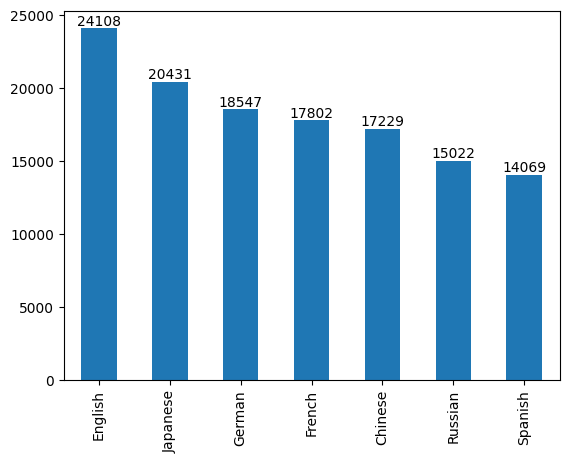


* What other methods other than grid search would be suitable to get the model for all languages?
  * hyperparameter of the models can be observed from ACF and PACF plot, random search.